In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile

from IPython.display import display
from PIL import Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data/'

In [3]:
def download_progress_hook(count, block_size, total_size):
    '''
    A hook to report the progress of a download, in the event of a slow
    connection.
    '''
    global last_percent_reported
    percent = int(100 * count * block_size /total_size)
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write('%s%%' %percent)
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()
        last_percent_reported = percent

In [4]:
def maybe_download(filename, expected_bytes, force=False):
    '''Download a file if not present; make sure it is the right size'''
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download', filename)
        filename, _ = urlretrieve(url + filename, 
                                  dest_filename, 
                                  reporthook=download_progress_hook)
        print('\nDownload Complete.')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + 
                        '. Can you get it with a browser?')
    return dest_filename

In [5]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./data/notMNIST_large.tar.gz
Found and verified ./data/notMNIST_small.tar.gz


Extract the data from the compressed tarball.  Contains directories A - J

In [6]:
n_classes = 10
np.random.seed(266)

In [7]:
def maybe_extract(filename, force=False):
    # remove '.tar.gz'
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        # override with `force=True`
        print('%s already present - not rextracting %s' %(root, filename))
    else:
        print('Extracting data for %s. May take a while...' %root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))
                    if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != n_classes:
        raise Exception('Expected %d folders, (one per class). Got %d' 
                        %(n_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [9]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./data/notMNIST_large. May take a while...
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
Extracting data for ./data/notMNIST_small. May take a while...
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


# Problem 1

Take a peek at some of the data to make sure it looks sensible. Each example should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image_index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [10]:
image_size = 28    # w and h in px
pixel_depth = 255. # max value for each px

In [11]:
def load_letter(folder, min_images):
    '''Load data for a single letter'''
    image_files = os.listdir(folder)
    data_set = np.ndarray(shape=(len(image_files), image_size, image_size),
                          dtype=np.float32)
    print(folder)
    n_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' 
                                %str(image_data.shape))
            data_set[n_images, :, :] = image_data
            n_images += 1
        except IOError as e:
            print('Could not read ', image_file, ':', e, '--skipping...')
    data_set = data_set[0:n_images, :, :]
    if n_images < min_images:
        raise Exception('Many fewer images than expected (%d < %d)' 
                        %(n_images, min_images))
    print('Full data set tensor:', data_set.shape)
    print('Mean:', np.mean(data_set))
    print('SD:', np.std(data_set))
    return data_set

In [12]:
def maybe_pickle(data_folders, min_class_img, force=False):
    data_set_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        data_set_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present--Not repickling')
        else:
            print('Pickling %s...' %set_filename)
            data_set = load_letter(folder, min_class_img)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(data_set, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return data_set_names

In [13]:
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./data/notMNIST_large/A.pickle...
./data/notMNIST_large/A
Could not read  ./data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' --skipping...
Could not read  ./data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' --skipping...
Could not read  ./data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' --skipping...
Full data set tensor: (52909, 28, 28)
Mean: -0.12825
SD: 0.443121
Pickling ./data/notMNIST_large/B.pickle...
./data/notMNIST_large/B
Could not read  ./data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' --skipping...
Full data set tensor: (52911, 28, 28)
Mean: -0.00756303
SD: 0.454491

In [14]:
# Display some sample images
!ls ./data/notMNIST_large/

A        B.pickle D        E.pickle G        H.pickle J
A.pickle C        D.pickle F        G.pickle I        J.pickle
B        C.pickle E        F.pickle H        I.pickle


In [32]:
sample = os.listdir('./data/notMNIST_large/D/')[8]

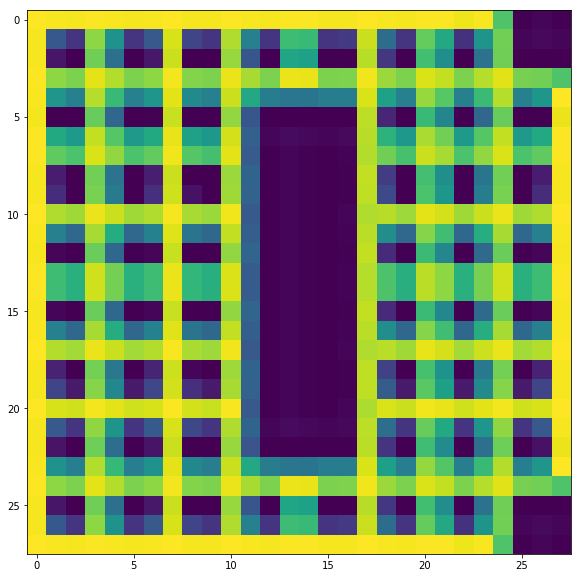

In [33]:
D1 = plt.imread('./data/notMNIST_large/D/' + sample)
plt.imshow(D1);

In [34]:
# Check no. of images similar for each letter
for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    print(letter, ':', len(os.listdir('./data/notMNIST_large/%s' %letter)))

A : 52912
B : 52912
C : 52912
D : 52912
E : 52912
F : 52912
G : 52912
H : 52912
I : 52912
J : 52911
